### **Proyek Akhir: Menyelesaikan Masalah Attrition Rate pada Perusahaan Jaya Jaya Maju**

*   Nama        : Hudas Fatkhan Arhabi
*   Email       : vnhyde@gmail.com
*   ID Dicoding :

## Persiapan

Menyiapkan library yang dibutuhkan

In [7]:
import pandas as pd
import zipfile,os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV

Menyiapkan data yang akan digunakan
## Data Understanding




In [8]:
drive.mount('/content/drive', force_remount=True)

# load dataframe
main_dir = img_dir = '/content/drive/MyDrive/supa/' # change as fit
jaya_df = pd.read_csv(os.path.join(main_dir,'employee_data.csv'))

# check df content
print(jaya_df.head())
print(jaya_df.describe(include="all"))
print(jaya_df.info())
print(jaya_df.isnull().sum())

Mounted at /content/drive
   EmployeeId  Age  Attrition     BusinessTravel  DailyRate  \
0           1   38        NaN  Travel_Frequently       1444   
1           2   37        1.0      Travel_Rarely       1141   
2           3   51        1.0      Travel_Rarely       1323   
3           4   42        0.0  Travel_Frequently        555   
4           5   40        NaN      Travel_Rarely       1194   

               Department  DistanceFromHome  Education EducationField  \
0         Human Resources                 1          4          Other   
1  Research & Development                11          2        Medical   
2  Research & Development                 4          4  Life Sciences   
3                   Sales                26          3      Marketing   
4  Research & Development                 2          4        Medical   

   EmployeeCount  ...  RelationshipSatisfaction StandardHours  \
0              1  ...                         2            80   
1              1  ...     

## Data Preparation / Preprocessing



In [9]:
# Separate rows with missing attrition
attr_null_df = jaya_df[jaya_df['Attrition'].isnull()]
attr_ok_df = jaya_df[jaya_df['Attrition'].notnull()]

# Features and target
X = attr_ok_df.drop(columns=['EmployeeId', 'Attrition'])
y = attr_ok_df['Attrition']

# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipelines for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Apply transformations
X_preprocessed = preprocessor.fit_transform(X)

## Modeling

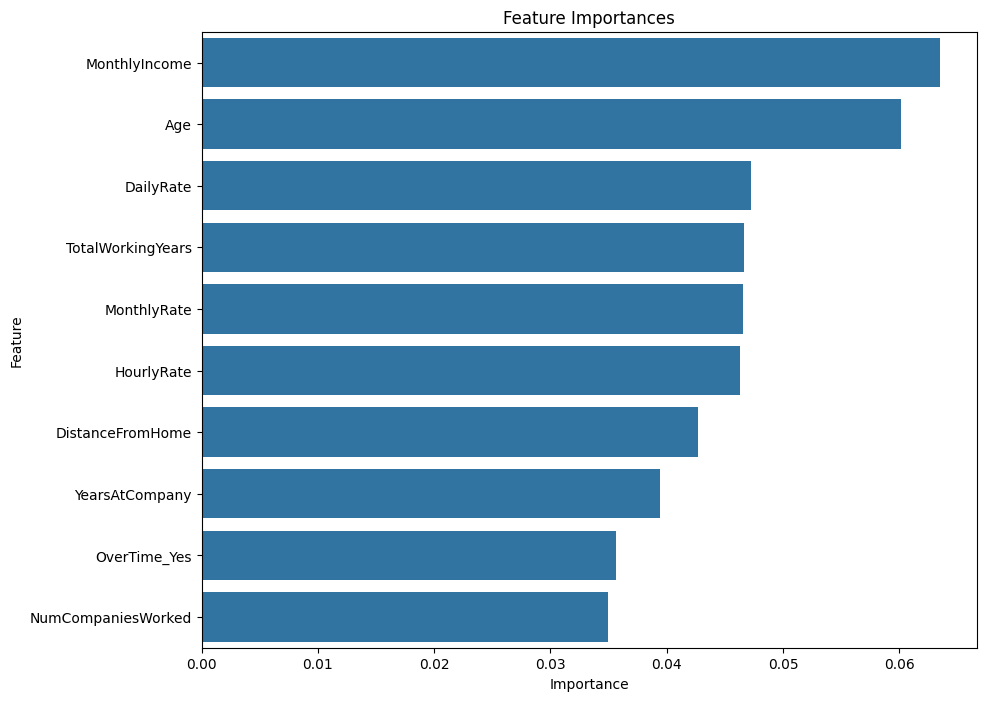

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calibrate the classifier to obtain probability estimates
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train, y_train)

# Obtain probability estimates for the test set
probabilities_test = calibrated_model.predict_proba(X_test)[:, 1]

# Example threshold selection (you may adjust this based on your requirements)
threshold = 0.7

# Generate predictions based on the selected threshold
predictions_test = (probabilities_test >= threshold).astype(int)

# Extract feature importances
importances = model.feature_importances_

# Get feature names
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols.tolist() + onehot_feature_names.tolist()

# Check if the lengths match
assert len(all_feature_names) == len(importances), "Lengths of feature names and importances do not match."

# Create a DataFrame for visualization and display top 10 Factor
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df = importance_df.head(10)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# Preprocess the missing data
X_full = jaya_df.drop(columns=['EmployeeId', 'Attrition'])
X_full_preprocessed = preprocessor.transform(X_full)

# Predict attrition probabilities for the entire dataset
full_probabilities = calibrated_model.predict_proba(X_full_preprocessed)[:, 1]

# Generate predictions based on the selected threshold
full_predictions = (full_probabilities >= threshold).astype(int)

# Preprocess the missing data
X_missing = attr_null_df.drop(columns=['EmployeeId', 'Attrition'])
X_missing_preprocessed = preprocessor.transform(X_missing)

# Predict the missing attrition values
missing_predictions = model.predict(X_missing_preprocessed)

## Evaluation

In [11]:
# Evaluate the model calculate mean accuracy
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Mean accuracy: {scores.mean()}')

# Calculate F1 score
f1 = f1_score(y_test, predictions_test)
print(f'F1 Score: {f1}')

# Fill the missing values
jaya_df.loc[jaya_df['Attrition'].isnull(), 'Attrition'] = missing_predictions

# Verify imputation
attNullCount = jaya_df['Attrition'].isnull().sum()
print(f'Attrition Null Count : {attNullCount}')

# Combine predictions with actual labels for evaluation
results = pd.DataFrame({
    'EmployeeId': jaya_df['EmployeeId'],
    'Attrition' : jaya_df['Attrition'],
    'Predicted': full_predictions,
    'Probability': full_probabilities})

# Filter out individuals who have already left the company
results_filtered = results[(jaya_df['Attrition'].notnull()) & (jaya_df['Attrition'] != 1)]

# Sort results by probability in descending order
results_sorted = results_filtered.sort_values(by='Probability', ascending=False)
print(results_sorted.head(10))

# print result to csv
importance_df.to_csv(os.path.join(main_dir, 'importance_df.csv'), index=False)

# print clean dataframe to csv
results_sorted.to_csv(os.path.join(main_dir, 'predict_result.csv'), index=False)

# print clean dataframe to csv
jaya_df.to_csv(os.path.join(main_dir, 'employee_data_clean.csv'), index=False)

Mean accuracy: 0.8463348416289593
F1 Score: 0.3673469387755102
Attrition Null Count : 0
      EmployeeId  Attrition  Predicted  Probability
732          733        0.0          1     0.789033
758          759        0.0          1     0.757863
97            98        0.0          1     0.723701
1103        1104        0.0          1     0.723701
1249        1250        0.0          0     0.686711
910          911        0.0          0     0.605534
743          744        0.0          0     0.605534
1213        1214        0.0          0     0.518084
1246        1247        0.0          0     0.473590
852          853        0.0          0     0.473590
